# Домашнее задание № 9. Предобученные трансформеры 

### Задание 1 (8 баллов).
Дообучите 3 предобученных модели на тех же данных, что и в семинаре. Сравните качество и выберите лучшую. 
Модели должны отличаться друг от друга не только параметрами ru/en/multilingual, base/large, cased/uncased. Все три выбранные модели должны работать лучше, чем бейзлайн без дообучения (т.е. если модель не работает, попробуйте другую).




In [ ]:
!pip install transformers

In [4]:
import os, re
import numpy as np
from time import time
from sklearn.model_selection import train_test_split
import pandas as pd
from collections import Counter
from string import punctuation
import matplotlib.pyplot as plt
%matplotlib inline


import tensorflow as tf
from transformers import TFAutoModel
from transformers import AutoTokenizer

from sklearn.metrics import classification_report

Считываем датасет — небольшой набор текстов из Ленты

In [5]:
data = pd.read_csv('lenta_sample.csv')

Распределение текстов по тематикам

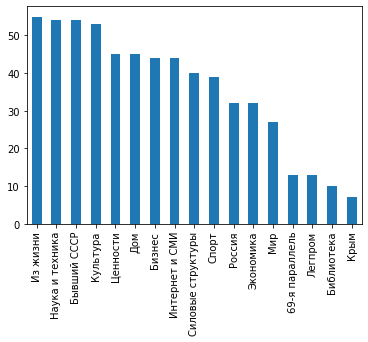

In [ ]:
data['topic'].value_counts().plot(kind="bar")
plt.show()

### bert-base-ru-cased

Дообучим модель [bert-base-ru-cased](https://huggingface.co/Geotrend/bert-base-ru-cased)

Массив с эталонными классами (*y*) будет одинаковым для всех последующих моделей

In [6]:
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

y = tf.keras.utils.to_categorical([label2id[label] for label in data.topic.values])

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("Geotrend/bert-base-ru-cased")
bert_base_ru_cased = TFAutoModel.from_pretrained("Geotrend/bert-base-ru-cased", trainable=True)

Для каждого из 3-х классификаторов будем брать встроенный токенизатор выбранной модели (поэтому обучающая выборка X будет задаваться отдельно для кадого классификатора)

In [ ]:
X = []

for text in data.title: # для обучения берем только заголовки
    ids = tokenizer.encode(text)
    X.append(ids[:512])

X = tf.keras.preprocessing.sequence.pad_sequences(X, padding='post', maxlen=512)

In [ ]:
# добавим стратификацию, так как в данных дисбаланс классов
train_index, valid_index = train_test_split(list(range(len(X))), test_size=0.05, stratify=data.topic)

In [ ]:
X_train, y_train = X[train_index], y[train_index]
X_valid, y_valid = X[valid_index], y[valid_index]

In [ ]:
input_word_ids = tf.keras.layers.Input(shape=(512,), dtype=tf.int32,
                                     name="input_ids")

output = bert_base_ru_cased({"input_ids":input_word_ids})
drop = tf.keras.layers.Dropout(0.3)(output[0][:, 0]) 
dense = tf.keras.layers.Dense(y.shape[1], activation='softmax')(drop)

bert_base_ru_cased_clf = tf.keras.Model(inputs=input_word_ids, outputs=dense)


bert_base_ru_cased_clf.compile(tf.optimizers.Adam(learning_rate=2e-6,), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy', 
                           tf.keras.metrics.RecallAtPrecision(0.80, name='rec_prec')])

In [ ]:
bert_base_ru_cased_clf.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=2,
          epochs=15)

Epoch 1/15
288/288 [==============================] - 152s 529ms/step - loss: 0.0394 - accuracy: 0.9931 - rec_prec: 1.0000 - val_loss: 2.7254 - val_accuracy: 0.4516 - val_rec_prec: 0.0000e+00
Epoch 2/15
288/288 [==============================] - 152s 528ms/step - loss: 0.0352 - accuracy: 0.9931 - rec_prec: 1.0000 - val_loss: 2.8069 - val_accuracy: 0.4516 - val_rec_prec: 0.0000e+00
Epoch 3/15
288/288 [==============================] - 152s 527ms/step - loss: 0.0168 - accuracy: 0.9983 - rec_prec: 1.0000 - val_loss: 2.8885 - val_accuracy: 0.5161 - val_rec_prec: 0.0000e+00
Epoch 4/15
288/288 [==============================] - 152s 528ms/step - loss: 0.0194 - accuracy: 0.9983 - rec_prec: 1.0000 - val_loss: 3.0422 - val_accuracy: 0.4194 - val_rec_prec: 0.0000e+00
Epoch 5/15
288/288 [==============================] - 152s 528ms/step - loss: 0.0191 - accuracy: 0.9983 - rec_prec: 1.0000 - val_loss: 2.9448 - val_accuracy: 0.4194 - val_rec_prec: 0.0000e+00
Epoch 6/15
288/288 [====================

In [ ]:
pred = bert_base_ru_cased_clf.predict(X_valid, batch_size=5).argmax(1)

In [ ]:
print(classification_report(y_valid.argmax(1), pred, labels=list(range(len(label2id))),
                            target_names=list(label2id), zero_division=0))

                   precision    recall  f1-score   support

         Культура       0.33      0.33      0.33         3
      Бывший СССР       0.50      0.67      0.57         3
         Ценности       0.00      0.00      0.00         2
             Крым       0.00      0.00      0.00         0
              Мир       0.00      0.00      0.00         1
          Легпром       0.00      0.00      0.00         1
       Библиотека       0.00      0.00      0.00         0
            Спорт       0.00      0.00      0.00         2
         Из жизни       0.50      0.33      0.40         3
           Бизнес       0.67      1.00      0.80         2
           Россия       0.00      0.00      0.00         2
              Дом       0.33      0.50      0.40         2
   69-я параллель       0.00      0.00      0.00         1
        Экономика       1.00      1.00      1.00         2
  Наука и техника       0.67      0.67      0.67         3
Силовые структуры       0.50      0.50      0.50       

### smaller-LaBSE

Вторая модель: [samller-LaBSE](https://huggingface.co/setu4993/smaller-LaBSE)

In [ ]:
tokenizer_2 = AutoTokenizer.from_pretrained("setu4993/smaller-LaBSE")
smaller_LaBSE = TFAutoModel.from_pretrained('setu4993/smaller-LaBSE', trainable=True)

In [8]:
X = []

for text in data.title: 
    ids = tokenizer_2.encode(text) # используем токенизатор для LaBSE
    X.append(ids[:512])

X = tf.keras.preprocessing.sequence.pad_sequences(X, padding='post', maxlen=512)

train_index, valid_index = train_test_split(list(range(len(X))), test_size=0.05, stratify=data.topic)

X_train, y_train = X[train_index], y[train_index]
X_valid, y_valid = X[valid_index], y[valid_index]

In [9]:
input_word_ids = tf.keras.layers.Input(shape=(512,), dtype=tf.int32,
                                     name="input_ids")

output = smaller_LaBSE({"input_ids":input_word_ids})
drop = tf.keras.layers.Dropout(0.3)(output[0][:, 0]) 
dense = tf.keras.layers.Dense(y.shape[1], activation='softmax')(drop)

smaller_LaBSE_clf = tf.keras.Model(inputs=input_word_ids, outputs=dense)


smaller_LaBSE_clf.compile(tf.optimizers.Adam(learning_rate=2e-6,), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy', 
                           tf.keras.metrics.RecallAtPrecision(0.80, name='rec_prec')])

In [10]:
smaller_LaBSE_clf.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=2,
          epochs=15)

Epoch 1/15
288/288 [==============================] - 107s 336ms/step - loss: 2.9599 - accuracy: 0.0677 - rec_prec: 0.0000e+00 - val_loss: 2.7518 - val_accuracy: 0.1613 - val_rec_prec: 0.0000e+00
Epoch 2/15
288/288 [==============================] - 95s 328ms/step - loss: 2.8618 - accuracy: 0.0816 - rec_prec: 0.0000e+00 - val_loss: 2.7075 - val_accuracy: 0.1613 - val_rec_prec: 0.0645
Epoch 3/15
288/288 [==============================] - 94s 328ms/step - loss: 2.5630 - accuracy: 0.1858 - rec_prec: 0.0000e+00 - val_loss: 2.5674 - val_accuracy: 0.2258 - val_rec_prec: 0.0645
Epoch 4/15
288/288 [==============================] - 95s 328ms/step - loss: 2.2204 - accuracy: 0.3073 - rec_prec: 0.0087 - val_loss: 2.2846 - val_accuracy: 0.2581 - val_rec_prec: 0.0645
Epoch 5/15
288/288 [==============================] - 94s 328ms/step - loss: 1.8186 - accuracy: 0.4253 - rec_prec: 0.1111 - val_loss: 2.2518 - val_accuracy: 0.3871 - val_rec_prec: 0.0323
Epoch 6/15
288/288 [============================

In [11]:
pred_2 = smaller_LaBSE_clf.predict(X_valid, batch_size=5).argmax(1)

In [12]:
print(classification_report(y_valid.argmax(1), pred_2, labels=list(range(len(label2id))),
                            target_names=list(label2id), zero_division=0))

                   precision    recall  f1-score   support

         Ценности       0.00      0.00      0.00         2
  Наука и техника       0.50      0.67      0.57         3
          Легпром       0.00      0.00      0.00         1
            Спорт       0.50      0.50      0.50         2
         Культура       0.50      0.33      0.40         3
   Интернет и СМИ       0.33      0.50      0.40         2
              Дом       0.67      1.00      0.80         2
         Из жизни       0.50      0.33      0.40         3
           Бизнес       0.33      0.50      0.40         2
   69-я параллель       1.00      1.00      1.00         1
             Крым       0.00      0.00      0.00         0
              Мир       0.00      0.00      0.00         1
           Россия       0.00      0.00      0.00         2
      Бывший СССР       0.60      1.00      0.75         3
        Экономика       0.00      0.00      0.00         2
       Библиотека       0.00      0.00      0.00       

### rubert-base-cased-sentiment-rurewiews

Третья модель: [rubert-base-cased-sentiment-rurewiews](https://huggingface.co/blanchefort/rubert-base-cased-sentiment-rurewiews)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("blanchefort/rubert-base-cased-sentiment-rurewiews")
rubase_sentiment = TFAutoModel.from_pretrained('blanchefort/rubert-base-cased-sentiment-rurewiews', trainable=True)

In [21]:
X = []

for text in data.title: # для обучения берем только заголовки
    ids = tokenizer.encode(text)
    X.append(ids[:512])

X = tf.keras.preprocessing.sequence.pad_sequences(X, padding='post', maxlen=512)

train_index, valid_index = train_test_split(list(range(len(X))), test_size=0.05, stratify=data.topic)

X_train, y_train = X[train_index], y[train_index]
X_valid, y_valid = X[valid_index], y[valid_index]

In [22]:
input_word_ids = tf.keras.layers.Input(shape=(512,), dtype=tf.int32,
                                     name="input_ids")

output = rubase_sentiment({"input_ids":input_word_ids})
drop = tf.keras.layers.Dropout(0.3)(output[0][:, 0]) 
dense = tf.keras.layers.Dense(y.shape[1], activation='softmax')(drop)

rubase_sentiment_clf = tf.keras.Model(inputs=input_word_ids, outputs=dense)


rubase_sentiment_clf.compile(tf.optimizers.Adam(learning_rate=2e-6,), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy', 
                           tf.keras.metrics.RecallAtPrecision(0.80, name='rec_prec')])

In [23]:
rubase_sentiment_clf.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=2,
          epochs=15)

Epoch 1/15
288/288 [==============================] - 97s 305ms/step - loss: 2.8787 - accuracy: 0.0764 - rec_prec: 0.0000e+00 - val_loss: 2.7295 - val_accuracy: 0.0645 - val_rec_prec: 0.0000e+00
Epoch 2/15
288/288 [==============================] - 87s 302ms/step - loss: 2.8100 - accuracy: 0.0799 - rec_prec: 0.0000e+00 - val_loss: 2.7311 - val_accuracy: 0.0645 - val_rec_prec: 0.0000e+00
Epoch 3/15
288/288 [==============================] - 88s 306ms/step - loss: 2.7863 - accuracy: 0.0833 - rec_prec: 0.0000e+00 - val_loss: 2.7024 - val_accuracy: 0.1935 - val_rec_prec: 0.0000e+00
Epoch 4/15
288/288 [==============================] - 88s 306ms/step - loss: 2.7451 - accuracy: 0.1128 - rec_prec: 0.0000e+00 - val_loss: 2.5935 - val_accuracy: 0.2581 - val_rec_prec: 0.0323
Epoch 5/15
288/288 [==============================] - 88s 306ms/step - loss: 2.5854 - accuracy: 0.1788 - rec_prec: 0.0000e+00 - val_loss: 2.4319 - val_accuracy: 0.2581 - val_rec_prec: 0.0000e+00
Epoch 6/15
288/288 [=========

In [24]:
pred_3 = rubase_sentiment_clf.predict(X_valid, batch_size=5).argmax(1)

In [26]:
print(classification_report(y_valid.argmax(1), pred_3, labels=list(range(len(label2id))),
                            target_names=list(label2id), zero_division=0))

                   precision    recall  f1-score   support

         Ценности       1.00      0.50      0.67         2
  Наука и техника       0.50      0.67      0.57         3
          Легпром       0.00      0.00      0.00         1
            Спорт       1.00      1.00      1.00         2
         Культура       0.50      0.33      0.40         3
   Интернет и СМИ       1.00      1.00      1.00         2
              Дом       0.50      1.00      0.67         2
         Из жизни       1.00      1.00      1.00         3
           Бизнес       0.50      0.50      0.50         2
   69-я параллель       0.00      0.00      0.00         1
             Крым       0.00      0.00      0.00         0
              Мир       0.50      1.00      0.67         1
           Россия       0.33      0.50      0.40         2
      Бывший СССР       0.50      0.67      0.57         3
        Экономика       0.00      0.00      0.00         2
       Библиотека       0.00      0.00      0.00       

### Анализ результатов. Выбор лучшей модели

| Model | F1-score |
| --- | --- | 
| bert-base-ru-cased | 0.39 |
| smaller-LaBSE  | 0.37 |
| rubert-base-cased-sentiment-rurewiews | **0.57** |

<br>

Лучший результат показала модель **rubert-base-cased-sentiment-rurewiews** (f1 = 0.57). Несмотря на то, что модель изначально была предобучена на отзывах, она неплохо справилась с классификацией новостных заголовков.

### Задание  2 (2 балла)

Ответьте на следующие вопросы (напишите хотя бы по несколько предложений):

1) Чем ROBERTA отличается от BERT? В какой статье описана ROBERTA?

— **BERT без NSP.** Основное отличие RoBERTa от BERT — отсутствие NSP (next sentence perdicion) на этапе предобучения модели. NSP — задача бинарной классификации, заключающаяся в определении вероятности совместного появления двух предложений в тексте. В оригинальном BERT был задействован NSP и модель получала на вход пары предложений. Создатели RoBERTa смогли доказать, что использование NSP не влияет на производительность BERT. В RoBERTa не используется NSP, поэтому сегменты текста подаются в модель не попарно, а по отдельности.
<br>
— **Больший объем обучающих данных.** BERT: 16 GB (Book Corpus + Wikipedia). RoBERTa: 160 GB (16GB BERT data + 144GB additional).
<br>
— **Различие в токенизации.** RoBERTa: byte-level BPE; BERT: character-level
BPE.
<br>
— Динамичное маскирование (masking) вместо статичного.
<br>
— Тренировка большими батчами.
<br>
<br>
Статья с описанием RoBERTa: [RoBERTa: A Robustly Optimized BERT Pretraining Approach](https://arxiv.org/pdf/1907.11692.pdf)

2) Чем модель T5 отличается от ROBERTA/BERT? 

Модель T5 (Text-to-Text Transfer Transformer) позволяет на основе входного текста генерировать целевой текст, тогда как RoBERTa и BERT способны предсказывать только метки классов. 


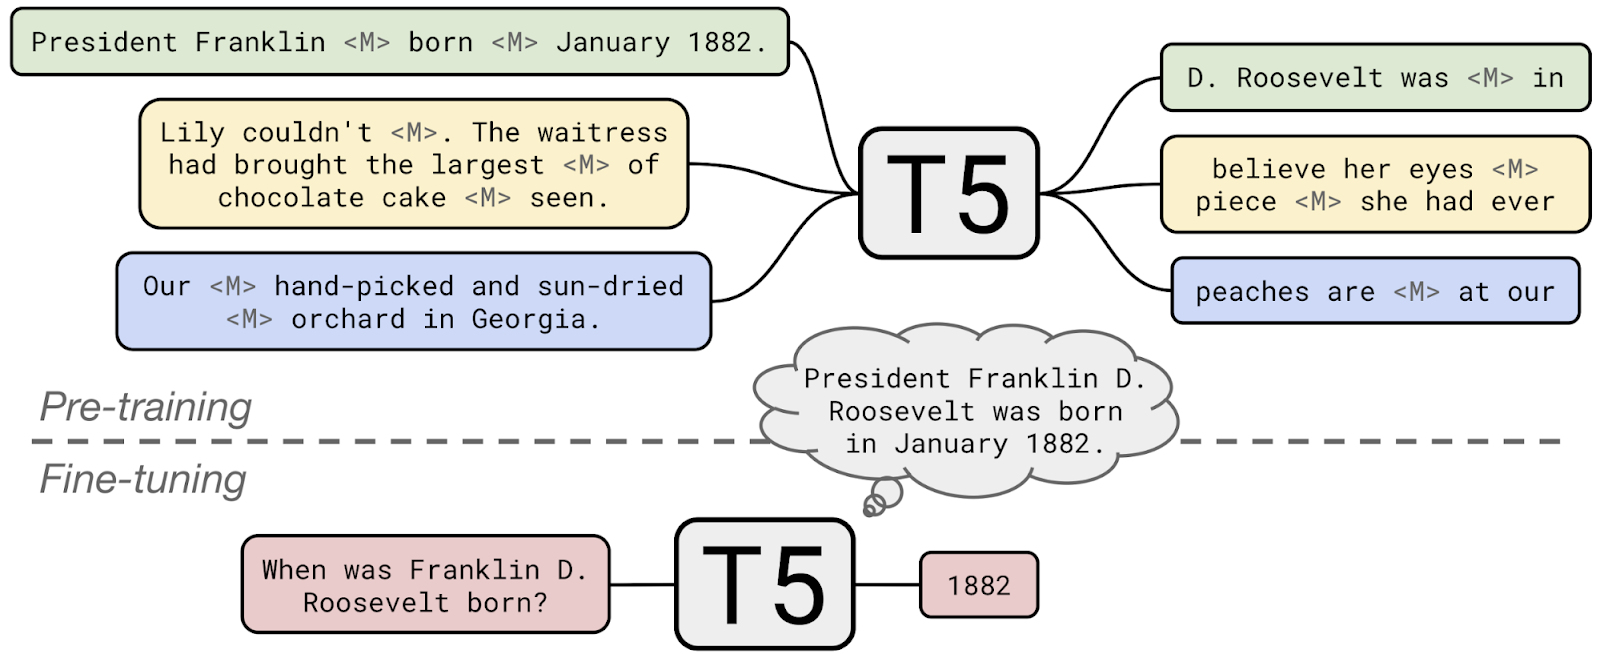